# Palm Tree Counter

In [1]:
# Palm Tree Counter - Computer Vision Solution
# This program detects and counts palm trees in plantation images

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import urllib.request
from PIL import Image, ImageDraw, ImageFont
import io

In [3]:
def download_sample_image():
    """Download the sample image from the provided URL"""
    url = "https://storage.googleapis.com/648010c1-f244-4641-98f2-73ff6c1b4e99/ai_assignment_20241202_count.jpeg"
    try:
        urllib.request.urlretrieve(url, "count.jpg")
        print("Sample image downloaded successfully as 'count.jpg'")
        return True
    except Exception as e:
        print(f"Error downloading sample image: {e}")
        return False

In [4]:
def preprocess_image(image):
    """Preprocess the image for better palm tree detection"""
    # Convert to different color spaces for analysis
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Create a mask for green vegetation (palm trees)
    # Palm trees typically have green crowns
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Apply morphological operations to clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel)
    green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_CLOSE, kernel)

    return green_mask

In [5]:
def detect_palm_trees_contours(image, green_mask):
    """Detect palm trees using contour detection"""
    # Find contours in the green mask
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area and shape
    palm_trees = []
    min_area = 500  # Minimum area for a palm tree crown
    max_area = 10000  # Maximum area for a palm tree crown

    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area < area < max_area:
            # Get bounding rectangle
            x, y, w, h = cv2.boundingRect(contour)

            # Filter based on aspect ratio (palm tree crowns are roughly circular)
            aspect_ratio = float(w) / h
            if 0.5 < aspect_ratio < 2.0:  # Reasonable aspect ratio for palm crowns
                palm_trees.append((x, y, w, h, area))

    return palm_trees

In [6]:
def detect_palm_trees_hough_circles(image, green_mask):
    """Detect palm trees using Hough Circle Transform"""
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(green_mask, (9, 9), 2)

    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=30,  # Minimum distance between circle centers
        param1=50,   # Higher threshold for edge detection
        param2=30,   # Accumulator threshold for center detection
        minRadius=10, # Minimum circle radius
        maxRadius=50  # Maximum circle radius
    )

    palm_trees = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            # Convert circle to bounding box
            bbox_x = max(0, x - r)
            bbox_y = max(0, y - r)
            bbox_w = 2 * r
            bbox_h = 2 * r
            palm_trees.append((bbox_x, bbox_y, bbox_w, bbox_h, np.pi * r * r))

    return palm_trees

In [7]:
def merge_overlapping_detections(detections, overlap_threshold=0.5):
    """Merge overlapping detections to avoid double counting"""
    if len(detections) == 0:
        return []

    # Sort detections by area (largest first)
    detections = sorted(detections, key=lambda x: x[4], reverse=True)

    merged = []
    used = [False] * len(detections)

    for i, det1 in enumerate(detections):
        if used[i]:
            continue

        x1, y1, w1, h1, area1 = det1
        merged.append(det1)
        used[i] = True

        # Check for overlaps with remaining detections
        for j in range(i + 1, len(detections)):
            if used[j]:
                continue

            x2, y2, w2, h2, area2 = detections[j]

            # Calculate intersection
            xi1 = max(x1, x2)
            yi1 = max(y1, y2)
            xi2 = min(x1 + w1, x2 + w2)
            yi2 = min(y1 + h1, y2 + h2)

            if xi2 > xi1 and yi2 > yi1:
                intersection = (xi2 - xi1) * (yi2 - yi1)
                union = area1 + area2 - intersection
                iou = intersection / union if union > 0 else 0

                if iou > overlap_threshold:
                    used[j] = True

    return merged

In [8]:
def draw_bounding_boxes(image, detections):
    """Draw numbered bounding boxes on the image"""
    output_image = image.copy()

    # Define colors and font
    box_color = (0, 255, 0)  # Green
    text_color = (255, 255, 255)  # White
    text_bg_color = (0, 0, 0)  # Black background for text

    for i, (x, y, w, h, _) in enumerate(detections):
        # Draw bounding box
        cv2.rectangle(output_image, (x, y), (x + w, y + h), box_color, 2)

        # Prepare text
        text = str(i + 1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2

        # Get text size
        (text_w, text_h), _ = cv2.getTextSize(text, font, font_scale, thickness)

        # Draw text background
        cv2.rectangle(output_image, (x, y - text_h - 10), (x + text_w + 10, y), text_bg_color, -1)

        # Draw text
        cv2.putText(output_image, text, (x + 5, y - 5), font, font_scale, text_color, thickness)

    return output_image

In [9]:
def count_palm_trees(image_path="count.jpg"):
    """Main function to count palm trees in the image"""
    try:
        # Load the image
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")

        print(f"Processing image: {image_path}")
        print(f"Image dimensions: {image.shape[1]} x {image.shape[0]}")

        # Preprocess the image
        green_mask = preprocess_image(image)

        # Detect palm trees using multiple methods
        detections_contours = detect_palm_trees_contours(image, green_mask)
        detections_circles = detect_palm_trees_hough_circles(image, green_mask)

        # Combine detections from both methods
        all_detections = detections_contours + detections_circles

        # Merge overlapping detections
        final_detections = merge_overlapping_detections(all_detections)

        # Draw bounding boxes
        output_image = draw_bounding_boxes(image, final_detections)

        # Save the output image
        output_path = "count_result.jpg"
        cv2.imwrite(output_path, output_image)

        # Display results
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(green_mask, cmap='gray')
        plt.title("Green Vegetation Mask")
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Palm Trees: {len(final_detections)}")
        plt.axis('off')

        # Show detection statistics
        plt.subplot(2, 2, 4)
        plt.axis('off')
        stats_text = f"""
        Detection Results:

        Total Palm Trees Detected: {len(final_detections)}

        Method Breakdown:
        - Contour Detection: {len(detections_contours)}
        - Circle Detection: {len(detections_circles)}
        - After Merging Overlaps: {len(final_detections)}

        Output saved as: {output_path}
        """
        plt.text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center')

        plt.tight_layout()
        plt.show()

        print(f"\nPalm Tree Count: {len(final_detections)}")
        print(f"Output image saved as: {output_path}")

        return len(final_detections), output_path

    except Exception as e:
        print(f"Error processing image: {e}")
        return 0, None

Palm Tree Counter - Computer Vision Solution
Sample image downloaded successfully as 'count.jpg'
Processing image: count.jpg
Image dimensions: 5954 x 6978


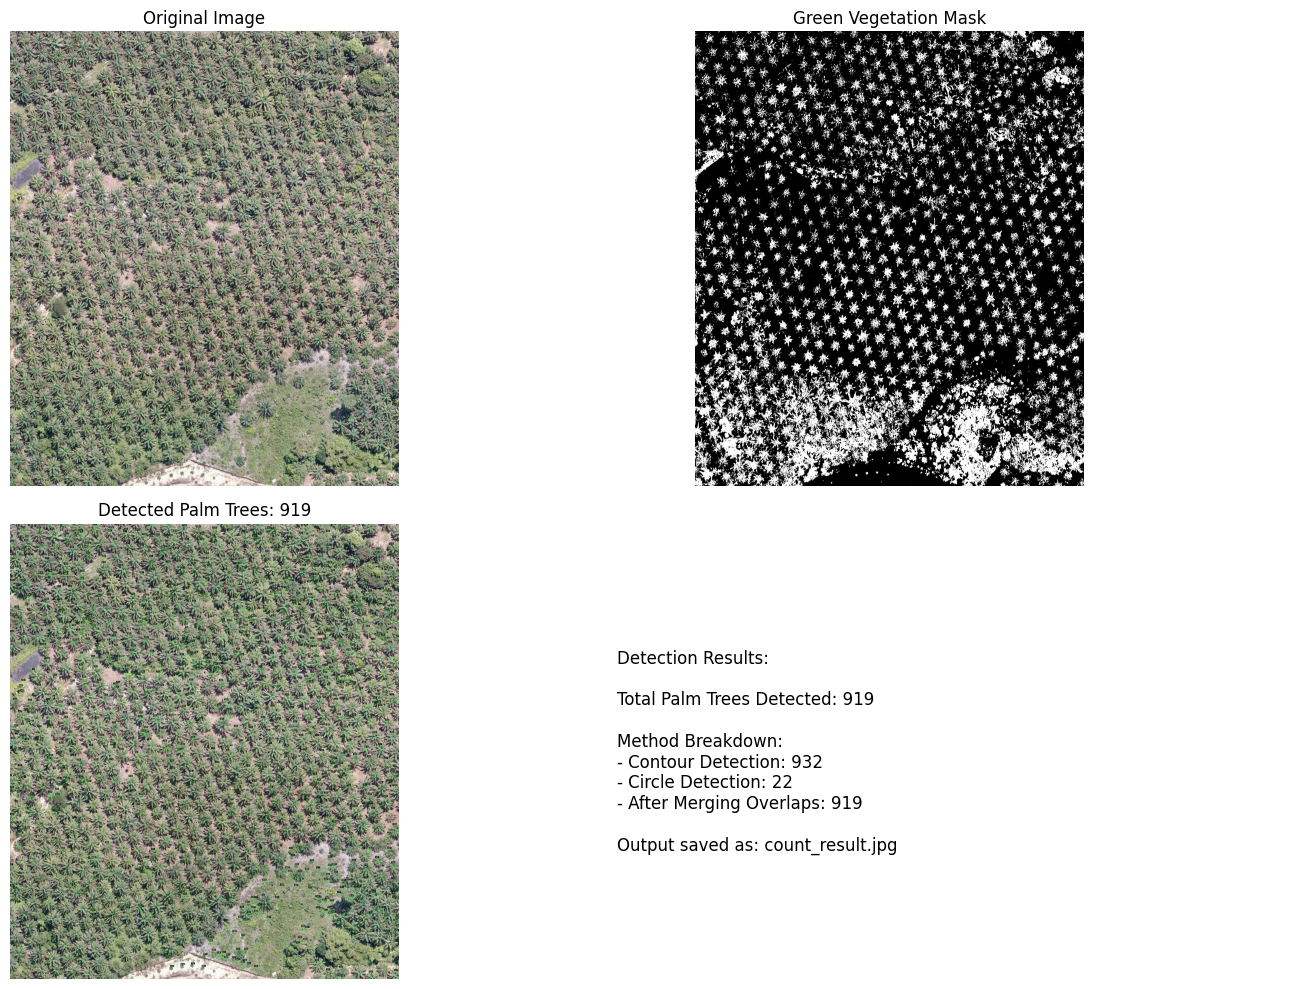


Palm Tree Count: 919
Output image saved as: count_result.jpg


In [10]:
# Main execution
if __name__ == "__main__":
    print("Palm Tree Counter - Computer Vision Solution")
    print("=" * 50)

    # Option 1: Download and use the sample image
    if download_sample_image():
        count, output_path = count_palm_trees("count.jpg")
    else:
        print("\nFailed to download sample image. Please upload your own 'count.jpg' file.")
        print("You can upload a file using the following code:")
        print("from google.colab import files")
        print("uploaded = files.upload()")

    # Option 2: Upload your own image (uncomment the lines below if needed)
    # print("\nAlternatively, upload your own image:")
    # uploaded = files.upload()
    # if uploaded:
    #     filename = list(uploaded.keys())[0]
    #     count, output_path = count_palm_trees(filename)

In [11]:
# Additional utility functions for fine-tuning detection parameters
def adjust_detection_parameters():
    """Function to help users adjust detection parameters interactively"""
    print("\nDetection Parameter Adjustment Guide:")
    print("1. If too many false positives: Increase min_area, decrease max_area")
    print("2. If missing palm trees: Decrease min_area, adjust color ranges")
    print("3. If detecting overlapping trees as one: Decrease minDist in Hough circles")
    print("4. If getting duplicate detections: Increase overlap_threshold in merging")

def analyze_image_colors(image_path="count.jpg"):
    """Analyze color distribution to help tune color-based detection"""
    image = cv2.imread(image_path)
    if image is None:
        print("Could not load image")
        return

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(hsv[:,:,0].flatten(), bins=180, alpha=0.7)
    plt.title('Hue Distribution')
    plt.xlabel('Hue')

    plt.subplot(1, 3, 2)
    plt.hist(hsv[:,:,1].flatten(), bins=256, alpha=0.7)
    plt.title('Saturation Distribution')
    plt.xlabel('Saturation')

    plt.subplot(1, 3, 3)
    plt.hist(hsv[:,:,2].flatten(), bins=256, alpha=0.7)
    plt.title('Value Distribution')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

print("\nAvailable functions:")
print("- count_palm_trees(): Main function to process the image")
print("- analyze_image_colors(): Analyze color distribution for parameter tuning")
print("- adjust_detection_parameters(): Get tips for adjusting detection parameters")


Available functions:
- count_palm_trees(): Main function to process the image
- analyze_image_colors(): Analyze color distribution for parameter tuning
- adjust_detection_parameters(): Get tips for adjusting detection parameters
